# about this notebook
두 가지 변경사항을 python script들에 반영하기 전에 시험해본다. 변경 사항은 다음과 같다.  
- img를 읽어올 때, json도 같이 읽어서 라벨 폴리곤을 그려넣는다. (파란색이 어떨까) -> 이것은 fp\_and\_cond\_input.csv 로 기존의 list_attr.csv를 대체할 수 있게 새로 저장하였다.
- img_generation_utils 의 batch generator도 바꿔서 파일 경로도 return 하도록 한다. ->이건 테스트 하여 반영하였다. 

In [110]:

import argparse
import json
import os
from matplotlib import pyplot as plt
import sys

import tensorflow as tf

from rz_cvae.utils import batch_generator, convert_batch_to_image_grid, read_data

# Read test_data.pickle 
test_data = read_data("./test_data")

#path = l/rz_cvae/image_data

In [111]:
len(test_data['img_paths'])

383

# 이미지 생성시 원본 경로도 출력하기
원래 이런 코드로 실행된다. 이걸 하면 이미지만 출력하는 것이 아니라 file paths도 출력되게 만들자. 그리고 지정 이미지에서 만들 수 있게 해도 좋겠는데  
```python
test_data = read_data("./test_data")
image_reconstruction(model, test_data, save_path=None) 
```

## rz_cvae/utils.py 의 함수

In [4]:
def create_image_batch(labels, model_name, use_train=False, path_return=False):
    """
    Returns the list of images corresponding to the given labels.
    """
    imgs = []
    paths = []
    imgs_id = [item[0] for item in labels]
    
    #hard code few lines...
    test_data = read_data("./test_data")
    img_paths = test_data['img_paths'][-len(test_data['test_img_ids']):] # split of test_data paths
    #img_paths = test_data['img_paths'][:-len(test_data['test_img_ids'])] # split of train_data paths
    path_cols=[0,1]

    for i in imgs_id:
        img = []
        for j in range(len(path_cols)):
            image_path = img_paths[i][j]
            paths.append(image_path)
            img.append(get_image(image_path, model_name))
        imgs.append(np.concatenate(tuple(img),axis=-1))
    if path_return=True:
        return imgs, paths
    else:
        return imgs

def get_image(image_path, model_name, img_resize = 1024):
    """
    Crops, resizes and normalizes the target image.
        - If model_name == Dense, the image is returned as a flattened numpy array with dim (64*64*3)
        - otherwise, the image is returned as a numpy array with dim (64,64,3)
    """

    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_resize, img_resize))
    img = np.array(img, dtype='float32')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img /= 255.0 # Normalization to [0.,1.]

    if model_name == "Dense" :
        img = img.ravel()
    
    return img

def batch_generator(batch_dim, test_labels, model_name):
    """
    Batch generator using the given list of labels.
    """
    while True:
        batch_imgs = []
        labels = []
        for label in (test_labels):
            labels.append(label)
            if len(labels) == batch_dim:
                batch_imgs, img_paths = create_image_batch(labels, model_name, path_return=True)
                batch_labels = [x[1] for x in labels]
                yield np.asarray(batch_imgs), np.asarray(batch_labels), img_paths
                batch_imgs = []
                labels = []
                batch_labels = []
        if batch_imgs:
            yield np.asarray(batch_imgs), np.asarray(batch_labels), img_paths

## img reconstruction 함수
rz_cvae/image_generation_utils.py

In [ ]:
def image_reconstruction(model, test_data, save_path=None):
    """
    Reconstructs and plots a bacth of test images.
    """

    batch_gen, paths = batch_generator(test_data['batch_size'], test_data['test_img_ids'], model_name = 'Conv')
    images, labels= next(batch_gen)
    model_output= model((images, labels), is_train = False)
    
    print(paths)
    
    f = plt.figure(figsize=(24,60))
    ax = f.add_subplot(1,2,1)
    ax.imshow(convert_batch_to_image_grid(images))
    plt.axis('off')

    ax = f.add_subplot(1,2,2)
    ax.imshow(convert_batch_to_image_grid(model_output['recon_img'].numpy()))
    plt.axis('off')
    
    if save_path :
        plt.savefig(save_path + "reconstruction.png")

    plt.show()
    plt.clf()

    print("Reconstruction of a batch of test set images.")


In [113]:
batch_gen = batch_generator(test_data['batch_size'], test_data['test_img_ids'], model_name = 'Conv')

In [114]:
len(test_data['img_paths'])

383

In [115]:
len(test_data['test_img_ids'])

20

In [119]:
td=test_data['img_paths'][-len(test_data['test_img_ids']):]
td

array([['sample_img/imgCrop_RI/20200928_13_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200928_13_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200928_14_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200928_14_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200928_15_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200928_15_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200928_16_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200928_16_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200929_09_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200929_09_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200929_10_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200929_10_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200929_11_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200929_11_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200929_12_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200929_12_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200929_13_RI.JPG.jpg',
        'sample_img/imgC

In [121]:
[x[0].split('/')[-1] for x in td] # x[0] for RI files, x[1] for CHL files

['20200928_13_RI.JPG.jpg',
 '20200928_14_RI.JPG.jpg',
 '20200928_15_RI.JPG.jpg',
 '20200928_16_RI.JPG.jpg',
 '20200929_09_RI.JPG.jpg',
 '20200929_10_RI.JPG.jpg',
 '20200929_11_RI.JPG.jpg',
 '20200929_12_RI.JPG.jpg',
 '20200929_13_RI.JPG.jpg',
 '20200929_14_RI.JPG.jpg',
 '20200929_15_RI.JPG.jpg',
 '20200929_16_RI.JPG.jpg',
 '20200930_09_RI.JPG.jpg',
 '20200930_10_RI.JPG.jpg',
 '20200930_11_RI.JPG.jpg',
 '20200930_12_RI.JPG.jpg',
 '20200930_13_RI.JPG.jpg',
 '20200930_14_RI.JPG.jpg',
 '20200930_15_RI.JPG.jpg',
 '20200930_16_RI.JPG.jpg']

# 이미지에 라벨 폴리곤 넣기

In [30]:
import os
path = 'image_data/RI'
data_files = os.listdir(path)

print(len([x for x in data_files if x.split('.')[-1]=='jpg']))

390


In [61]:
jsons = [x for x in data_files if x.split('.')[-1]=='json']
print(len(jsons),len(data_files))

269 659


In [62]:
import json
fp = open(os.path.join(path, jsons[1]), "r")
a=json.load(fp)
#a

In [63]:
points = a['shapes'][2]['points']
print(len(a['shapes']),points)

10 [[310.930576070901, 753.0162481536189], [303.8404726735598, 758.4815361890694], [302.8064992614475, 765.8670605612998], [309.1580502215657, 778.4224519940916], [317.13441654357456, 782.5583456425406], [319.3500738552437, 787.1373707533235], [318.4638109305761, 797.6248153618907], [320.384047267356, 814.9069423929099], [324.0768094534712, 823.1787296898079], [324.0768094534712, 830.2688330871492], [327.6218611521418, 832.6322008862629], [329.9852289512555, 844.7444608567208], [336.1890694239291, 846.5169867060562], [334.4165435745938, 829.6779911373708], [335.89364844903986, 819.781388478582], [342.39290989660265, 808.7031019202363], [344.7562776957164, 802.2038404726735], [347.2673559822747, 792.7503692762186], [342.8360413589365, 788.7621861152141], [332.4963072378139, 788.1713441654357], [343.27917282127027, 782.410635155096], [340.47267355982274, 773.1048744460857], [333.97341211225995, 776.354505169867], [328.65583456425406, 772.9571639586411], [325.25849335302803, 769.116691285

In [64]:
a['imageWidth'], type(a['imageWidth'])

(1216, int)

In [65]:
a['imageHeight']

1192

In [66]:
import numpy as np
import cv2 as cv

In [67]:
blue_color = (0,0,255)
img = np.zeros((a['imageHeight'], a['imageWidth'], 3), np.uint8)

for points in a['shapes']:
    img1 = np.zeros((a['imageHeight'], a['imageWidth'], 3), np.uint8)
    pts = np.array(points['points'], np.int32)
    pts = pts.reshape((-1, 1, 2))
    img1 = cv.polylines(img1, [pts], True, blue_color, 3)
    img = cv.add(img, img1)


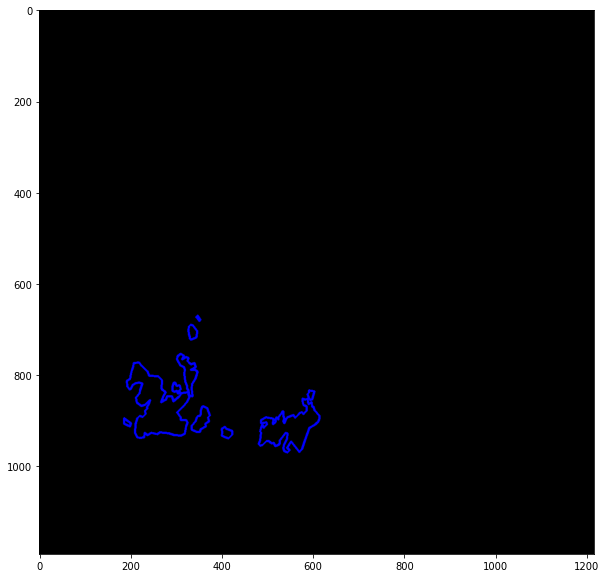

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(img)

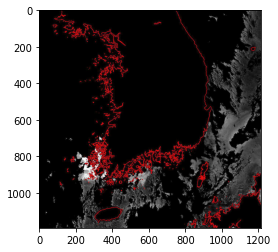

In [69]:
orig_img = plt.imread(os.path.join(path, a['imagePath']))
plt.imshow(orig_img)

In [70]:
print(orig_img.shape, img.shape)

(1192, 1216, 3) (1192, 1216, 3)


# 이미지 병합: 두 가지 방법
cv2.add 를 쓰는 것이 낫겠다.

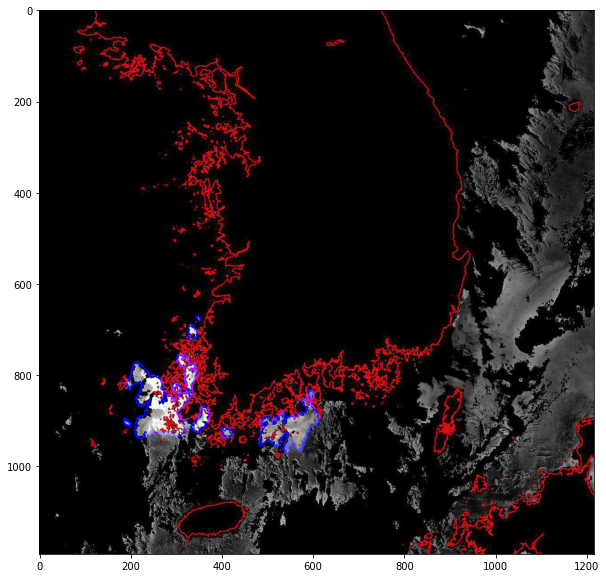

In [71]:
merged_img = cv.add(orig_img, img)
plt.figure(figsize=(10,10))
plt.imshow(merged_img)

이 방법은 조악하다.


```python
for i in range(len(orig_img)):
    for j in range(len(orig_img[0])):
        orig_img[i, j, 2] = min(np.int32(orig_img[i, j, 2])+img[i, j, 2], 255)
plt.figure(figsize=(10,10))
plt.imshow(orig_img)
```

## 데이터는 어떻게 저장할까?
크게 두 가지 방법을 생각할 수 있겠다.  
1. 병합된 이미지 따로 저장해두기 : 저장공간을 낭비하는 셈인데 그렇게 부담이 되진 않는다.  
2. 라벨 폴리곤 이미지만 따로 저장해두기 : 저장공간을 조금 낭비하는 셈인데 그렇게 부담이 되진 않는다.  
3. json을 가지고 이미지 불러올 때 합치기 : 저장공간이 아껴지는데 이걸 하면 batch를 구성할 때마다 위 과정을 되풀이해야 한다.  

## list_attr.csv 의 수정 방법
list_attr.csv 파일은 센서 데이터와 일시별 파일 경로를 포함하고 있다. RI_file 말고 column을 하나 더 추가해서 label에 관련된 파일을 넣자. 이미지이든 json 파일이든.  
list_attr.csv 파일은 [이 노트북](https://github.com/chhyyi/aiffelthon/blob/main/cvae_poc/cvae_poc.ipynb)으로 만들었다. 여기다 복붙하겠다. 다만 ri, chl에 더해 json 파일에 대한 처리도 같이 한다.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
path_RI = 'image_data/RI'
path_CHL = 'image_data/CHL'

sample_chls=os.listdir(path_CHL)
sample_chls=[os.path.join(path_CHL, i) for i in sample_chls]
sample_ris=os.listdir(path_RI)
jsons=[os.path.join(path_RI, i) for i in sample_ris if i.split('.')[-1]=='json']
sample_ris=[os.path.join(path_RI, i) for i in sample_ris if i.split('.')[-1]=='jpg']

#print(sample_chls)
print(len(sample_chls), len(sample_ris))


386 390


In [2]:
import pandas as pd
sample_chls_fn_split=[list(i.split('/')[-1].split('.')[0].split('_'))+[i] for i in sample_chls]
sample_ris_fn_split=[list(i.split('/')[-1].split('.')[0].split('_'))+[i] for i in sample_ris]
jsons_fn_split=[list(i.split('/')[-1].split('.')[0].split('_'))+[i] for i in jsons]

In [3]:
print(jsons_fn_split[0], sample_chls_fn_split[0], sample_ris_fn_split[0])

['20190825', '14', 'RI', 'image_data/RI/20190825_14_RI.JPG.jpg.json'] ['20200914', '12', 'CHL', 'image_data/CHL/20200914_12_CHL.JPG.jpg'] ['20200918', '12', 'RI', 'image_data/RI/20200918_12_RI.JPG.jpg.jpg']


In [4]:
sample_chls_df=pd.DataFrame(sample_chls_fn_split, columns=['date', 'hour', 'product','file'])
sample_ris_df=pd.DataFrame(sample_ris_fn_split, columns=['date', 'hour', 'product','file'])
jsons_df=pd.DataFrame(jsons_fn_split, columns=['date', 'hour', 'product','file'])

sample_ris_df.dropna(inplace=True)
#sample_ris_df['file']=sample_ris_df['file'].apply(lambda x:os.path.join(path_RI,x))
sample_chls_df.dropna(inplace=True)
#sample_chls_df['file']=sample_chls_df['file'].apply(lambda x:os.path.join(path_CHL,x))
jsons_df.dropna(inplace=True)
#jsons_df['file']=jsons_df['file'].apply(lambda x:os.path.join(path_RI,x))

sample_chls_df.sort_values(by=['date', 'hour'], inplace=True)
sample_ris_df.sort_values(by=['date', 'hour'], inplace=True)
jsons_df.sort_values(by=['date', 'hour'], inplace=True)

sample_ris_df['year']=sample_ris_df['date'].astype('datetime64[D]').apply(lambda x:x.year)
sample_ris_df['mm']=sample_ris_df['date'].astype('datetime64[D]').apply(lambda x:x.month)
sample_ris_df['dd']=sample_ris_df['date'].astype('datetime64[D]').apply(lambda x:x.day)
sample_ris_df['hh']=sample_ris_df['hour'].astype('int')
sample_ris_df.drop(columns=['date', 'hour'], inplace=True)
sample_ris_df.reset_index(drop=True, inplace=True)

sample_chls_df['year']=sample_chls_df['date'].astype('datetime64[D]').apply(lambda x:x.year)
sample_chls_df['mm']=sample_chls_df['date'].astype('datetime64[D]').apply(lambda x:x.month)
sample_chls_df['dd']=sample_chls_df['date'].astype('datetime64[D]').apply(lambda x:x.day)
sample_chls_df['hh']=sample_chls_df['hour'].astype('int')
sample_chls_df.drop(columns=['date', 'hour'], inplace=True)
sample_chls_df.reset_index(drop=True, inplace=True)


jsons_df['year']=jsons_df['date'].astype('datetime64[D]').apply(lambda x:x.year)
jsons_df['mm']=jsons_df['date'].astype('datetime64[D]').apply(lambda x:x.month)
jsons_df['dd']=jsons_df['date'].astype('datetime64[D]').apply(lambda x:x.day)
jsons_df['hh']=jsons_df['hour'].astype('int')
jsons_df.drop(columns=['date', 'hour'], inplace=True)
jsons_df.reset_index(drop=True, inplace=True)

sensory=os.path.join(os.getenv('HOME'), 'aiffel/aiffelthon/sample_data/observe_train_refined_with_datetime.csv')
sensory=pd.read_csv(sensory, index_col = 0)
sensory.drop(columns='interpolated', inplace=True)

In [5]:
sensory.iloc[:,:-5]=(sensory.iloc[:,:-5]-sensory.iloc[:,:-5].min())/(sensory.iloc[:,:-5].max()-sensory.iloc[:,:-5].min()) #distributed 0~1
sensory

,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s).1,풍향(deg).1,기온(°C).1,수온(°C).1,강수량(mm).1,...,풍속(m/s).4,풍향(deg).4,기온(°C).4,수온(°C).4,강수량(mm).4,적조발생,year,mm,dd,hh
39,0.136364,0.838889,0.458549,0.383562,0.0,0.047297,0.741667,0.492308,0.243386,0.0,...,0.078603,0.986111,0.748936,0.368421,0.0,0.0,2017,1,2,16
40,0.210744,0.825000,0.468912,0.388128,0.0,0.033784,0.711111,0.505128,0.253968,0.0,...,0.213974,0.013889,0.746099,0.364372,0.0,0.0,2017,1,2,17
41,0.194215,0.852778,0.479275,0.383562,0.0,0.057432,0.675000,0.500000,0.248677,0.0,...,0.248908,0.927778,0.747518,0.364372,0.0,0.0,2017,1,2,18
42,0.206612,0.813889,0.489637,0.360731,0.0,0.047297,0.711111,0.512821,0.243386,0.0,...,0.192140,0.930556,0.753191,0.364372,0.0,0.0,2017,1,2,19
43,0.276860,0.891667,0.484456,0.347032,0.0,0.226351,0.769444,0.530769,0.238095,0.0,...,0.288210,0.016667,0.751773,0.368421,0.0,0.0,2017,1,2,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50370,0.016529,0.580556,0.707254,0.707763,0.0,0.097973,0.386111,0.776923,0.693122,0.0,...,0.052402,0.016667,0.878014,0.732794,0.0,0.0,2022,9,30,19
50371,0.066116,0.602778,0.709845,0.698630,0.0,0.108108,0.400000,0.769231,0.687831,0.0,...,0.074236,0.052778,0.843972,0.696356,0.0,0.0,2022,9,30,20
50372,0.066116,0.691667,0.707254,0.698630,0.0,0.091216,0.400000,0.769231,0.682540,0.0,...,0.048035,0.961111,0.822695,0.684211,0.0,0.0,2022,9,30,21
50373,0.082645,0.730556,0.699482,0.716895,0.0,0.060811,0.497222,0.761538,0.682540,0.0,...,0.048035,0.922222,0.858156,0.676113,0.0,0.0,2022,9,30,22


원래 썼던 코드.

```python
dt_index=['year', 'mm', 'dd', 'hh']
merged_list=[] #will generate merge dataframe
tot_row=0
for ri_row in sample_ris_df.itertuples():
    ri_dt=ri_row[-4:]
    matched=0
    for chl_row in sample_chls_df.itertuples():
        chl_dt=chl_row[-4:]
        if (ri_dt==chl_dt):
            #print('{} exists in both df'.format(ri_dt))
            matched=1
            for sensory_row in sensory.itertuples():
                sensory_dt=sensory_row[-4:]
                if sensory_dt==ri_dt:
                    merged_list.append(ri_row[2:-4]+chl_row[2:-4]+sensory_row[1:-4])
                    tot_row+=1
                    matched=2
                    break
            for json_row in jsons_df.itertuples():
                json_dt = json_row[-4:]
                if json_dt==ri_dt:
                    merged_list.append(ri_row[2:-4]+chl_row[2:-4]+sensory_row[1:-4])
                    tot_row+=1
                    matched=3
    if matched==0:
        print('no matched chl data found for ', ri_dt)
    elif matched==1:
        print('no matched sensroy data found for', ri_dt)
        
                    
print(tot_row)
```

기존의 코드에는 문제가 조금 있다.
너무 무식한 방법이라 할 수 있겠다.
이건 어떻게든 merge를 써봅시다... tds는 테스트 데이터셋이란 뜻이다.

In [6]:
jsons_tds=jsons_df[:5]
ris_tds = sample_ris_df[:8]
chls_tds=sample_chls_df[1:9]

이렇게 꼽아서 ri를 기준으로 합치는데 chl이 없는 값을 버린다고 치면 7개가 남고 3개의 json경로가 붙어야 한다. 그런데 그냥 nan을 포함해서 통합돼도 상관없다. 중요한 건 RI가 있는 year, mm, dd, hh 기준으로 통합되는 것이다.

In [7]:
dt_index=['year', 'mm', 'dd', 'hh']

merged_df=ris_tds.merge(chls_tds, how='left', on=dt_index)
merged_df

,product_x,file_x,year,mm,dd,hh,product_y,file_y
0,RI,image_data/RI/20190820_09_RI.JPG.jpg.jpg,2019,8,20,9,NaN,NaN
1,RI,image_data/RI/20190820_10_RI.JPG.jpg.jpg,2019,8,20,10,CHL,image_data/CHL/20190820_10_CHL.JPG.jpg
2,RI,image_data/RI/20190820_11_RI.JPG.jpg.jpg,2019,8,20,11,CHL,image_data/CHL/20190820_11_CHL.JPG.jpg
3,RI,image_data/RI/20190820_12_RI.JPG.jpg.jpg,2019,8,20,12,CHL,image_data/CHL/20190820_12_CHL.JPG.jpg
4,RI,image_data/RI/20190820_13_RI.JPG.jpg.jpg,2019,8,20,13,CHL,image_data/CHL/20190820_13_CHL.JPG.jpg
5,RI,image_data/RI/20190820_14_RI.JPG.jpg.jpg,2019,8,20,14,CHL,image_data/CHL/20190820_14_CHL.JPG.jpg
6,RI,image_data/RI/20190820_15_RI.JPG.jpg.jpg,2019,8,20,15,CHL,image_data/CHL/20190820_15_CHL.JPG.jpg
7,RI,image_data/RI/20190820_16_RI.JPG.jpg.jpg,2019,8,20,16,CHL,image_data/CHL/20190820_16_CHL.JPG.jpg


In [8]:
ris_tds.columns

Index(['product', 'file', 'year', 'mm', 'dd', 'hh'], dtype='object')

In [9]:
ris_tds=ris_tds.rename(columns={'file':'RI_file'})
ris_tds

,product,RI_file,year,mm,dd,hh
0,RI,image_data/RI/20190820_09_RI.JPG.jpg.jpg,2019,8,20,9
1,RI,image_data/RI/20190820_10_RI.JPG.jpg.jpg,2019,8,20,10
2,RI,image_data/RI/20190820_11_RI.JPG.jpg.jpg,2019,8,20,11
3,RI,image_data/RI/20190820_12_RI.JPG.jpg.jpg,2019,8,20,12
4,RI,image_data/RI/20190820_13_RI.JPG.jpg.jpg,2019,8,20,13
5,RI,image_data/RI/20190820_14_RI.JPG.jpg.jpg,2019,8,20,14
6,RI,image_data/RI/20190820_15_RI.JPG.jpg.jpg,2019,8,20,15
7,RI,image_data/RI/20190820_16_RI.JPG.jpg.jpg,2019,8,20,16


In [10]:
ris_tds.drop(columns='product', inplace=True)
ris_tds

,RI_file,year,mm,dd,hh
0,image_data/RI/20190820_09_RI.JPG.jpg.jpg,2019,8,20,9
1,image_data/RI/20190820_10_RI.JPG.jpg.jpg,2019,8,20,10
2,image_data/RI/20190820_11_RI.JPG.jpg.jpg,2019,8,20,11
3,image_data/RI/20190820_12_RI.JPG.jpg.jpg,2019,8,20,12
4,image_data/RI/20190820_13_RI.JPG.jpg.jpg,2019,8,20,13
5,image_data/RI/20190820_14_RI.JPG.jpg.jpg,2019,8,20,14
6,image_data/RI/20190820_15_RI.JPG.jpg.jpg,2019,8,20,15
7,image_data/RI/20190820_16_RI.JPG.jpg.jpg,2019,8,20,16


In [11]:
merged_df=ris_tds.merge(chls_tds, how='left', on=dt_index)
merged_df

,RI_file,year,mm,dd,hh,product,file
0,image_data/RI/20190820_09_RI.JPG.jpg.jpg,2019,8,20,9,NaN,NaN
1,image_data/RI/20190820_10_RI.JPG.jpg.jpg,2019,8,20,10,CHL,image_data/CHL/20190820_10_CHL.JPG.jpg
2,image_data/RI/20190820_11_RI.JPG.jpg.jpg,2019,8,20,11,CHL,image_data/CHL/20190820_11_CHL.JPG.jpg
3,image_data/RI/20190820_12_RI.JPG.jpg.jpg,2019,8,20,12,CHL,image_data/CHL/20190820_12_CHL.JPG.jpg
4,image_data/RI/20190820_13_RI.JPG.jpg.jpg,2019,8,20,13,CHL,image_data/CHL/20190820_13_CHL.JPG.jpg
5,image_data/RI/20190820_14_RI.JPG.jpg.jpg,2019,8,20,14,CHL,image_data/CHL/20190820_14_CHL.JPG.jpg
6,image_data/RI/20190820_15_RI.JPG.jpg.jpg,2019,8,20,15,CHL,image_data/CHL/20190820_15_CHL.JPG.jpg
7,image_data/RI/20190820_16_RI.JPG.jpg.jpg,2019,8,20,16,CHL,image_data/CHL/20190820_16_CHL.JPG.jpg


In [12]:
merged_df=merged_df.rename({'file':'CHL_file'})
merged_df.drop(columns='product', inplace=True)
merged_df

,RI_file,year,mm,dd,hh,file
0,image_data/RI/20190820_09_RI.JPG.jpg.jpg,2019,8,20,9,NaN
1,image_data/RI/20190820_10_RI.JPG.jpg.jpg,2019,8,20,10,image_data/CHL/20190820_10_CHL.JPG.jpg
2,image_data/RI/20190820_11_RI.JPG.jpg.jpg,2019,8,20,11,image_data/CHL/20190820_11_CHL.JPG.jpg
3,image_data/RI/20190820_12_RI.JPG.jpg.jpg,2019,8,20,12,image_data/CHL/20190820_12_CHL.JPG.jpg
4,image_data/RI/20190820_13_RI.JPG.jpg.jpg,2019,8,20,13,image_data/CHL/20190820_13_CHL.JPG.jpg
5,image_data/RI/20190820_14_RI.JPG.jpg.jpg,2019,8,20,14,image_data/CHL/20190820_14_CHL.JPG.jpg
6,image_data/RI/20190820_15_RI.JPG.jpg.jpg,2019,8,20,15,image_data/CHL/20190820_15_CHL.JPG.jpg
7,image_data/RI/20190820_16_RI.JPG.jpg.jpg,2019,8,20,16,image_data/CHL/20190820_16_CHL.JPG.jpg


In [13]:
merged_df=merged_df.merge(sensory, how='left', on=dt_index)
merged_df

,RI_file,year,mm,dd,hh,file,풍속(m/s),풍향(deg),기온(°C),수온(°C),...,풍향(deg).3,기온(°C).3,수온(°C).3,강수량(mm).3,풍속(m/s).4,풍향(deg).4,기온(°C).4,수온(°C).4,강수량(mm).4,적조발생
0,image_data/RI/20190820_09_RI.JPG.jpg.jpg,2019,8,20,9,NaN,0.367769,0.194444,0.810881,0.808219,...,0.169444,0.867568,0.794643,0.0,0.240175,0.208333,0.926241,0.753036,0.0,1.0
1,image_data/RI/20190820_10_RI.JPG.jpg.jpg,2019,8,20,10,image_data/CHL/20190820_10_CHL.JPG.jpg,0.359504,0.186111,0.810881,0.794521,...,0.180556,0.864865,0.785714,0.0,0.253275,0.188889,0.927660,0.773279,0.0,1.0
2,image_data/RI/20190820_11_RI.JPG.jpg.jpg,2019,8,20,11,image_data/CHL/20190820_11_CHL.JPG.jpg,0.417355,0.200000,0.818653,0.817352,...,0.175000,0.864865,0.781250,0.0,0.248908,0.188889,0.924823,0.777328,0.0,1.0
3,image_data/RI/20190820_12_RI.JPG.jpg.jpg,2019,8,20,12,image_data/CHL/20190820_12_CHL.JPG.jpg,0.425620,0.197222,0.816062,0.826484,...,0.202778,0.859459,0.772321,0.0,0.290393,0.211111,0.926241,0.777328,0.0,1.0
4,image_data/RI/20190820_13_RI.JPG.jpg.jpg,2019,8,20,13,image_data/CHL/20190820_13_CHL.JPG.jpg,0.429752,0.216667,0.813472,0.831050,...,0.208333,0.864865,0.772321,0.0,0.331878,0.233333,0.927660,0.777328,0.0,1.0
5,image_data/RI/20190820_14_RI.JPG.jpg.jpg,2019,8,20,14,image_data/CHL/20190820_14_CHL.JPG.jpg,0.355372,0.208333,0.818653,0.844749,...,0.205556,0.862162,0.767857,0.0,0.375546,0.233333,0.926241,0.765182,0.0,1.0
6,image_data/RI/20190820_15_RI.JPG.jpg.jpg,2019,8,20,15,image_data/CHL/20190820_15_CHL.JPG.jpg,0.380165,0.197222,0.816062,0.853881,...,0.186111,0.862162,0.767857,0.0,0.436681,0.222222,0.934752,0.834008,0.0,1.0
7,image_data/RI/20190820_16_RI.JPG.jpg.jpg,2019,8,20,16,image_data/CHL/20190820_16_CHL.JPG.jpg,0.392562,0.191667,0.816062,0.849315,...,0.183333,0.862162,0.758929,0.0,0.436681,0.225000,0.929078,0.842105,0.0,1.0


In [14]:
merged_df = merged_df.dropna().merge(jsons_tds, how='left', on=dt_index)
merged_df

,RI_file,year,mm,dd,hh,file_x,풍속(m/s),풍향(deg),기온(°C),수온(°C),...,수온(°C).3,강수량(mm).3,풍속(m/s).4,풍향(deg).4,기온(°C).4,수온(°C).4,강수량(mm).4,적조발생,product,file_y
0,image_data/RI/20190820_10_RI.JPG.jpg.jpg,2019,8,20,10,image_data/CHL/20190820_10_CHL.JPG.jpg,0.359504,0.186111,0.810881,0.794521,...,0.785714,0.0,0.253275,0.188889,0.927660,0.773279,0.0,1.0,NaN,NaN
1,image_data/RI/20190820_11_RI.JPG.jpg.jpg,2019,8,20,11,image_data/CHL/20190820_11_CHL.JPG.jpg,0.417355,0.200000,0.818653,0.817352,...,0.781250,0.0,0.248908,0.188889,0.924823,0.777328,0.0,1.0,NaN,NaN
2,image_data/RI/20190820_12_RI.JPG.jpg.jpg,2019,8,20,12,image_data/CHL/20190820_12_CHL.JPG.jpg,0.425620,0.197222,0.816062,0.826484,...,0.772321,0.0,0.290393,0.211111,0.926241,0.777328,0.0,1.0,NaN,NaN
3,image_data/RI/20190820_13_RI.JPG.jpg.jpg,2019,8,20,13,image_data/CHL/20190820_13_CHL.JPG.jpg,0.429752,0.216667,0.813472,0.831050,...,0.772321,0.0,0.331878,0.233333,0.927660,0.777328,0.0,1.0,RI,image_data/RI/20190820_13_RI.JPG.jpg.json
4,image_data/RI/20190820_14_RI.JPG.jpg.jpg,2019,8,20,14,image_data/CHL/20190820_14_CHL.JPG.jpg,0.355372,0.208333,0.818653,0.844749,...,0.767857,0.0,0.375546,0.233333,0.926241,0.765182,0.0,1.0,RI,image_data/RI/20190820_14_RI.JPG.jpg.json
5,image_data/RI/20190820_15_RI.JPG.jpg.jpg,2019,8,20,15,image_data/CHL/20190820_15_CHL.JPG.jpg,0.380165,0.197222,0.816062,0.853881,...,0.767857,0.0,0.436681,0.222222,0.934752,0.834008,0.0,1.0,RI,image_data/RI/20190820_15_RI.JPG.jpg.json
6,image_data/RI/20190820_16_RI.JPG.jpg.jpg,2019,8,20,16,image_data/CHL/20190820_16_CHL.JPG.jpg,0.392562,0.191667,0.816062,0.849315,...,0.758929,0.0,0.436681,0.225000,0.929078,0.842105,0.0,1.0,NaN,NaN


## 실제 DF 통합

In [15]:
jsons_df=jsons_df.drop(columns='product')
sample_ris_df = sample_ris_df.drop(columns='product')
sample_chls_df=sample_chls_df.drop(columns='product')

In [16]:
jsons_df=jsons_df.rename(columns={'file':'json_file'})
sample_ris_df = sample_ris_df.rename(columns={'file':'RI_file'})
sample_chls_df = sample_chls_df.rename(columns={'file':'CHL_file'})

In [17]:
dt_index=['year', 'mm', 'dd', 'hh']

merged_df=sample_ris_df.merge(sample_chls_df, how='left', on=dt_index)
merged_df

,RI_file,year,mm,dd,hh,CHL_file
0,image_data/RI/20190820_09_RI.JPG.jpg.jpg,2019,8,20,9,image_data/CHL/20190820_09_CHL.JPG.jpg
1,image_data/RI/20190820_10_RI.JPG.jpg.jpg,2019,8,20,10,image_data/CHL/20190820_10_CHL.JPG.jpg
2,image_data/RI/20190820_11_RI.JPG.jpg.jpg,2019,8,20,11,image_data/CHL/20190820_11_CHL.JPG.jpg
3,image_data/RI/20190820_12_RI.JPG.jpg.jpg,2019,8,20,12,image_data/CHL/20190820_12_CHL.JPG.jpg
4,image_data/RI/20190820_13_RI.JPG.jpg.jpg,2019,8,20,13,image_data/CHL/20190820_13_CHL.JPG.jpg
...,...,...,...,...,...,...
385,image_data/RI/20200930_12_RI.JPG.jpg.jpg,2020,9,30,12,image_data/CHL/20200930_12_CHL.JPG.jpg
386,image_data/RI/20200930_13_RI.JPG.jpg.jpg,2020,9,30,13,image_data/CHL/20200930_13_CHL.JPG.jpg
387,image_data/RI/20200930_14_RI.JPG.jpg.jpg,2020,9,30,14,image_data/CHL/20200930_14_CHL.JPG.jpg
388,image_data/RI/20200930_15_RI.JPG.jpg.jpg,2020,9,30,15,image_data/CHL/20200930_15_CHL.JPG.jpg


In [18]:
print(merged_df.isna().sum())
merged_df=merged_df.dropna()
print(len(merged_df))

RI_file     0
year        0
mm          0
dd          0
hh          0
CHL_file    8
dtype: int64
382


In [19]:
merged_df = merged_df.merge(jsons_df, how='left', on=dt_index)
merged_df

,RI_file,year,mm,dd,hh,CHL_file,json_file
0,image_data/RI/20190820_09_RI.JPG.jpg.jpg,2019,8,20,9,image_data/CHL/20190820_09_CHL.JPG.jpg,image_data/RI/20190820_09_RI.JPG.jpg.json
1,image_data/RI/20190820_10_RI.JPG.jpg.jpg,2019,8,20,10,image_data/CHL/20190820_10_CHL.JPG.jpg,NaN
2,image_data/RI/20190820_11_RI.JPG.jpg.jpg,2019,8,20,11,image_data/CHL/20190820_11_CHL.JPG.jpg,NaN
3,image_data/RI/20190820_12_RI.JPG.jpg.jpg,2019,8,20,12,image_data/CHL/20190820_12_CHL.JPG.jpg,NaN
4,image_data/RI/20190820_13_RI.JPG.jpg.jpg,2019,8,20,13,image_data/CHL/20190820_13_CHL.JPG.jpg,image_data/RI/20190820_13_RI.JPG.jpg.json
...,...,...,...,...,...,...,...
377,image_data/RI/20200930_12_RI.JPG.jpg.jpg,2020,9,30,12,image_data/CHL/20200930_12_CHL.JPG.jpg,image_data/RI/20200930_12_RI.JPG.jpg.json
378,image_data/RI/20200930_13_RI.JPG.jpg.jpg,2020,9,30,13,image_data/CHL/20200930_13_CHL.JPG.jpg,image_data/RI/20200930_13_RI.JPG.jpg.json
379,image_data/RI/20200930_14_RI.JPG.jpg.jpg,2020,9,30,14,image_data/CHL/20200930_14_CHL.JPG.jpg,image_data/RI/20200930_14_RI.JPG.jpg.json
380,image_data/RI/20200930_15_RI.JPG.jpg.jpg,2020,9,30,15,image_data/CHL/20200930_15_CHL.JPG.jpg,image_data/RI/20200930_15_RI.JPG.jpg.json


In [20]:
merged_df=merged_df.merge(sensory, how='left', on=dt_index)
merged_df

,RI_file,year,mm,dd,hh,CHL_file,json_file,풍속(m/s),풍향(deg),기온(°C),...,풍향(deg).3,기온(°C).3,수온(°C).3,강수량(mm).3,풍속(m/s).4,풍향(deg).4,기온(°C).4,수온(°C).4,강수량(mm).4,적조발생
0,image_data/RI/20190820_09_RI.JPG.jpg.jpg,2019,8,20,9,image_data/CHL/20190820_09_CHL.JPG.jpg,image_data/RI/20190820_09_RI.JPG.jpg.json,0.367769,0.194444,0.810881,...,0.169444,0.867568,0.794643,0.0,0.240175,0.208333,0.926241,0.753036,0.0,1.0
1,image_data/RI/20190820_10_RI.JPG.jpg.jpg,2019,8,20,10,image_data/CHL/20190820_10_CHL.JPG.jpg,NaN,0.359504,0.186111,0.810881,...,0.180556,0.864865,0.785714,0.0,0.253275,0.188889,0.927660,0.773279,0.0,1.0
2,image_data/RI/20190820_11_RI.JPG.jpg.jpg,2019,8,20,11,image_data/CHL/20190820_11_CHL.JPG.jpg,NaN,0.417355,0.200000,0.818653,...,0.175000,0.864865,0.781250,0.0,0.248908,0.188889,0.924823,0.777328,0.0,1.0
3,image_data/RI/20190820_12_RI.JPG.jpg.jpg,2019,8,20,12,image_data/CHL/20190820_12_CHL.JPG.jpg,NaN,0.425620,0.197222,0.816062,...,0.202778,0.859459,0.772321,0.0,0.290393,0.211111,0.926241,0.777328,0.0,1.0
4,image_data/RI/20190820_13_RI.JPG.jpg.jpg,2019,8,20,13,image_data/CHL/20190820_13_CHL.JPG.jpg,image_data/RI/20190820_13_RI.JPG.jpg.json,0.429752,0.216667,0.813472,...,0.208333,0.864865,0.772321,0.0,0.331878,0.233333,0.927660,0.777328,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,image_data/RI/20200930_12_RI.JPG.jpg.jpg,2020,9,30,12,image_data/CHL/20200930_12_CHL.JPG.jpg,image_data/RI/20200930_12_RI.JPG.jpg.json,0.198347,0.108333,0.689119,...,0.116667,0.721622,0.611607,0.0,0.292576,0.052778,0.838298,0.700405,0.0,0.0
378,image_data/RI/20200930_13_RI.JPG.jpg.jpg,2020,9,30,13,image_data/CHL/20200930_13_CHL.JPG.jpg,image_data/RI/20200930_13_RI.JPG.jpg.json,0.169421,0.086111,0.686528,...,0.111111,0.729730,0.616071,0.0,0.283843,0.030556,0.859574,0.700405,0.0,0.0
379,image_data/RI/20200930_14_RI.JPG.jpg.jpg,2020,9,30,14,image_data/CHL/20200930_14_CHL.JPG.jpg,image_data/RI/20200930_14_RI.JPG.jpg.json,0.181818,0.136111,0.696891,...,0.200000,0.735135,0.620536,0.0,0.288210,0.008333,0.883688,0.700405,0.0,0.0
380,image_data/RI/20200930_15_RI.JPG.jpg.jpg,2020,9,30,15,image_data/CHL/20200930_15_CHL.JPG.jpg,image_data/RI/20200930_15_RI.JPG.jpg.json,0.165289,0.177778,0.699482,...,0.200000,0.740541,0.620536,0.0,0.305677,0.972222,0.886525,0.700405,0.0,0.0


In [21]:
merged_df.isna().sum()

RI_file        0
year           0
mm             0
dd             0
hh             0
CHL_file       0
json_file    118
풍속(m/s)        0
풍향(deg)        0
기온(°C)         0
수온(°C)         0
강수량(mm)        0
풍속(m/s).1      0
풍향(deg).1      0
기온(°C).1       0
수온(°C).1       0
강수량(mm).1      0
풍속(m/s).2      0
풍향(deg).2      0
기온(°C).2       0
수온(°C).2       0
강수량(mm).2      0
풍속(m/s).3      0
풍향(deg).3      0
기온(°C).3       0
수온(°C).3       0
강수량(mm).3      0
풍속(m/s).4      0
풍향(deg).4      0
기온(°C).4       0
수온(°C).4       0
강수량(mm).4      0
적조발생           0
dtype: int64

In [22]:
merged_df.columns

Index(['RI_file', 'year', 'mm', 'dd', 'hh', 'CHL_file', 'json_file', '풍속(m/s)',
       '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '풍속(m/s).1', '풍향(deg).1',
       '기온(°C).1', '수온(°C).1', '강수량(mm).1', '풍속(m/s).2', '풍향(deg).2',
       '기온(°C).2', '수온(°C).2', '강수량(mm).2', '풍속(m/s).3', '풍향(deg).3',
       '기온(°C).3', '수온(°C).3', '강수량(mm).3', '풍속(m/s).4', '풍향(deg).4',
       '기온(°C).4', '수온(°C).4', '강수량(mm).4', '적조발생'],
      dtype='object')

In [23]:
merged_df=merged_df[['RI_file', 'CHL_file', 'json_file', '풍속(m/s)',
       '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '풍속(m/s).1', '풍향(deg).1',
       '기온(°C).1', '수온(°C).1', '강수량(mm).1', '풍속(m/s).2', '풍향(deg).2',
       '기온(°C).2', '수온(°C).2', '강수량(mm).2', '풍속(m/s).3', '풍향(deg).3',
       '기온(°C).3', '수온(°C).3', '강수량(mm).3', '풍속(m/s).4', '풍향(deg).4',
       '기온(°C).4', '수온(°C).4', '강수량(mm).4', '적조발생']]
merged_df

,RI_file,CHL_file,json_file,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s).1,풍향(deg).1,...,풍향(deg).3,기온(°C).3,수온(°C).3,강수량(mm).3,풍속(m/s).4,풍향(deg).4,기온(°C).4,수온(°C).4,강수량(mm).4,적조발생
0,image_data/RI/20190820_09_RI.JPG.jpg.jpg,image_data/CHL/20190820_09_CHL.JPG.jpg,image_data/RI/20190820_09_RI.JPG.jpg.json,0.367769,0.194444,0.810881,0.808219,0.0,0.297297,0.122222,...,0.169444,0.867568,0.794643,0.0,0.240175,0.208333,0.926241,0.753036,0.0,1.0
1,image_data/RI/20190820_10_RI.JPG.jpg.jpg,image_data/CHL/20190820_10_CHL.JPG.jpg,NaN,0.359504,0.186111,0.810881,0.794521,0.0,0.334459,0.077778,...,0.180556,0.864865,0.785714,0.0,0.253275,0.188889,0.927660,0.773279,0.0,1.0
2,image_data/RI/20190820_11_RI.JPG.jpg.jpg,image_data/CHL/20190820_11_CHL.JPG.jpg,NaN,0.417355,0.200000,0.818653,0.817352,0.0,0.266892,0.097222,...,0.175000,0.864865,0.781250,0.0,0.248908,0.188889,0.924823,0.777328,0.0,1.0
3,image_data/RI/20190820_12_RI.JPG.jpg.jpg,image_data/CHL/20190820_12_CHL.JPG.jpg,NaN,0.425620,0.197222,0.816062,0.826484,0.0,0.202703,0.197222,...,0.202778,0.859459,0.772321,0.0,0.290393,0.211111,0.926241,0.777328,0.0,1.0
4,image_data/RI/20190820_13_RI.JPG.jpg.jpg,image_data/CHL/20190820_13_CHL.JPG.jpg,image_data/RI/20190820_13_RI.JPG.jpg.json,0.429752,0.216667,0.813472,0.831050,0.0,0.185811,0.211111,...,0.208333,0.864865,0.772321,0.0,0.331878,0.233333,0.927660,0.777328,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,image_data/RI/20200930_12_RI.JPG.jpg.jpg,image_data/CHL/20200930_12_CHL.JPG.jpg,image_data/RI/20200930_12_RI.JPG.jpg.json,0.198347,0.108333,0.689119,0.689498,0.0,0.263514,0.077778,...,0.116667,0.721622,0.611607,0.0,0.292576,0.052778,0.838298,0.700405,0.0,0.0
378,image_data/RI/20200930_13_RI.JPG.jpg.jpg,image_data/CHL/20200930_13_CHL.JPG.jpg,image_data/RI/20200930_13_RI.JPG.jpg.json,0.169421,0.086111,0.686528,0.689498,0.0,0.270270,0.083333,...,0.111111,0.729730,0.616071,0.0,0.283843,0.030556,0.859574,0.700405,0.0,0.0
379,image_data/RI/20200930_14_RI.JPG.jpg.jpg,image_data/CHL/20200930_14_CHL.JPG.jpg,image_data/RI/20200930_14_RI.JPG.jpg.json,0.181818,0.136111,0.696891,0.694064,0.0,0.260135,0.058333,...,0.200000,0.735135,0.620536,0.0,0.288210,0.008333,0.883688,0.700405,0.0,0.0
380,image_data/RI/20200930_15_RI.JPG.jpg.jpg,image_data/CHL/20200930_15_CHL.JPG.jpg,image_data/RI/20200930_15_RI.JPG.jpg.json,0.165289,0.177778,0.699482,0.680365,0.0,0.236486,0.061111,...,0.200000,0.740541,0.620536,0.0,0.305677,0.972222,0.886525,0.700405,0.0,0.0


# 저장  
1. 통합된 dataframe은 fp_and_cond_input.csv 라는 이름으로 저장합니다.  
2. 파란색으로 label을 그리는 함수를 만들어 둡시다.

In [24]:
merged_df.to_csv("fp_and_cond_input.csv")

In [25]:
import pandas as pd
merged_df=pd.read_csv("fp_and_cond_input.csv", index_col = 0)

In [28]:
import pandas as pd
import os
from pathlib import Path
import json
import numpy as np
import cv2

class LabelledIMG():
    
    def __init__(self, file_path_df,
                 img_path_col='RI_file',
                 json_path_col='json_file'):
        """
        def __init__(self, file_path_df, img_path_col='RI_file', json_path_col='json_file')
        file_path_df should contain two columns with file path. one for image file and one for json file.
        """
        self.fp_df = file_path_df #[[img_path_col, json_path_col]]
        self.img_path_col = img_path_col
        self.json_path_col = json_path_col
    
    def add_labelled_img_path_to_df(self, df, save_dir):
        """
        It makes new conditional input csv files, with labelled image path.
        """
        df.loc[:,'lbl_img_path']=df[self.img_path_col].apply(lambda x: os.path.join(save_dir, x.split('/')[-1]))
        return df
    
    def gen_and_save(self, save_dir='labelled_imgs'):
        """
        it will generate labelled images to save_dir.
        """
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        self.fp_df = self.add_labelled_img_path_to_df(self.fp_df, save_dir)
        
        for j in range(len(self.fp_df)):
            json_path=self.fp_df[self.json_path_col][j]
            no_json = merged_df['json_file'].isna()
            if no_json[j]:
                orig_img = plt.imread(self.fp_df[self.img_path_col][j])
                orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
                cv2.imwrite(self.fp_df.loc[j,'lbl_img_path'], orig_img)
            else:
                fp = open(json_path, "r")
                a=json.load(fp)

                blue_color = (0,0,255)
                img = np.zeros((a['imageHeight'], a['imageWidth'], 3), np.uint8)

                for points in a['shapes']:
                    img1 = np.zeros((a['imageHeight'], a['imageWidth'], 3), np.uint8)
                    pts = np.array(points['points'], np.int32)
                    pts = pts.reshape((-1, 1, 2))
                    img1 = cv2.polylines(img1, [pts], True, blue_color, 3)
                    img = cv2.add(img, img1)

                orig_img = plt.imread(os.path.join(path, a['imagePath']))
                merged_img = cv2.add(orig_img, img)
                merged_img = cv2.cvtColor(merged_img, cv2.COLOR_BGR2RGB)
                cv2.imwrite(self.fp_df.loc[j,'lbl_img_path'], merged_img)
                
        self.fp_df.loc[:,self.json_path_col]=self.fp_df['lbl_img_path']
        self.fp_df.drop(columns='lbl_img_path', inplace=True)
        self.fp_df.rename(columns={self.json_path_col:'lbl_img_path'}, inplace=True)
        self.fp_df.to_csv("fp_and_cond_input.csv")
        
labelled_img = LabelledIMG(merged_df)

In [31]:
labelled_img.gen_and_save("labelled_images")

In [32]:
ds=pd.read_csv("fp_and_cond_input.csv", index_col=0)
ds

,RI_file,CHL_file,lbl_img_path,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s).1,풍향(deg).1,...,풍향(deg).3,기온(°C).3,수온(°C).3,강수량(mm).3,풍속(m/s).4,풍향(deg).4,기온(°C).4,수온(°C).4,강수량(mm).4,적조발생
0,image_data/RI/20190820_09_RI.JPG.jpg.jpg,image_data/CHL/20190820_09_CHL.JPG.jpg,labelled_images/20190820_09_RI.JPG.jpg.jpg,0.367769,0.194444,0.810881,0.808219,0.0,0.297297,0.122222,...,0.169444,0.867568,0.794643,0.0,0.240175,0.208333,0.926241,0.753036,0.0,1.0
1,image_data/RI/20190820_10_RI.JPG.jpg.jpg,image_data/CHL/20190820_10_CHL.JPG.jpg,labelled_images/20190820_10_RI.JPG.jpg.jpg,0.359504,0.186111,0.810881,0.794521,0.0,0.334459,0.077778,...,0.180556,0.864865,0.785714,0.0,0.253275,0.188889,0.927660,0.773279,0.0,1.0
2,image_data/RI/20190820_11_RI.JPG.jpg.jpg,image_data/CHL/20190820_11_CHL.JPG.jpg,labelled_images/20190820_11_RI.JPG.jpg.jpg,0.417355,0.200000,0.818653,0.817352,0.0,0.266892,0.097222,...,0.175000,0.864865,0.781250,0.0,0.248908,0.188889,0.924823,0.777328,0.0,1.0
3,image_data/RI/20190820_12_RI.JPG.jpg.jpg,image_data/CHL/20190820_12_CHL.JPG.jpg,labelled_images/20190820_12_RI.JPG.jpg.jpg,0.425620,0.197222,0.816062,0.826484,0.0,0.202703,0.197222,...,0.202778,0.859459,0.772321,0.0,0.290393,0.211111,0.926241,0.777328,0.0,1.0
4,image_data/RI/20190820_13_RI.JPG.jpg.jpg,image_data/CHL/20190820_13_CHL.JPG.jpg,labelled_images/20190820_13_RI.JPG.jpg.jpg,0.429752,0.216667,0.813472,0.831050,0.0,0.185811,0.211111,...,0.208333,0.864865,0.772321,0.0,0.331878,0.233333,0.927660,0.777328,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,image_data/RI/20200930_12_RI.JPG.jpg.jpg,image_data/CHL/20200930_12_CHL.JPG.jpg,labelled_images/20200930_12_RI.JPG.jpg.jpg,0.198347,0.108333,0.689119,0.689498,0.0,0.263514,0.077778,...,0.116667,0.721622,0.611607,0.0,0.292576,0.052778,0.838298,0.700405,0.0,0.0
378,image_data/RI/20200930_13_RI.JPG.jpg.jpg,image_data/CHL/20200930_13_CHL.JPG.jpg,labelled_images/20200930_13_RI.JPG.jpg.jpg,0.169421,0.086111,0.686528,0.689498,0.0,0.270270,0.083333,...,0.111111,0.729730,0.616071,0.0,0.283843,0.030556,0.859574,0.700405,0.0,0.0
379,image_data/RI/20200930_14_RI.JPG.jpg.jpg,image_data/CHL/20200930_14_CHL.JPG.jpg,labelled_images/20200930_14_RI.JPG.jpg.jpg,0.181818,0.136111,0.696891,0.694064,0.0,0.260135,0.058333,...,0.200000,0.735135,0.620536,0.0,0.288210,0.008333,0.883688,0.700405,0.0,0.0
380,image_data/RI/20200930_15_RI.JPG.jpg.jpg,image_data/CHL/20200930_15_CHL.JPG.jpg,labelled_images/20200930_15_RI.JPG.jpg.jpg,0.165289,0.177778,0.699482,0.680365,0.0,0.236486,0.061111,...,0.200000,0.740541,0.620536,0.0,0.305677,0.972222,0.886525,0.700405,0.0,0.0
